<a href="https://colab.research.google.com/github/Khushil-Modi/SJSU/blob/main/CMPE%20297/Assignment%202/CMPE_297_Assignment_2(b)_Node_Classification_using_GCN_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node classification with Graph Convolutional Network (GCN)



In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data Preparation


---


### Loading the CORA network

In [ ]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

The `info` method can help us verify that our loaded graph matches the description:

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories, with some categories more common than others:

In [ ]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn's `train_test_split` function.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

Note using stratified sampling gives the following counts:

In [ ]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Genetic_Algorithms,22
Probabilistic_Methods,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be compared against the model's soft-max output. To do this conversion we can use the `LabelBinarizer` transform. Another option would be the `pandas.get_dummies` function, but the scikit-learn transform allows us to do the inverse transform easily later in the notebook, to interpret the predictions.

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

The CORA dataset contains attributes `w_x` that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero. These numeric attributes have been automatically included in the `StellarGraph` instance `G`, and so we do not have to do any further conversion.

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

To create a Keras model we now expose the input and output tensors of the GCN model for node prediction, via the `GCN.in_out_tensors` method:

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices_2')>

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

## 3. Training and evaluating

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer. Our task is a categorical prediction task, so a categorical cross-entropy loss function is appropriate. Even though we're doing graph ML with StellarGraph, we're still working with conventional Keras prediction values, so we can use the loss function from Keras directly.

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


As we're training the model, we'll want to also keep track of its generalisation performance on the validation set, which means creating another data generator, using our `FullBatchNodeGenerator` we created above.

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

We can directly use the `EarlyStopping` functionality to stop training if the validation accuracy stops improving.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 1.9379 - acc: 0.1429 - val_loss: 1.9070 - val_acc: 0.3660 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: 1.8971 - acc: 0.3786 - val_loss: 1.8660 - val_acc: 0.3360 - 79ms/epoch - 79ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8469 - acc: 0.3429 - val_loss: 1.8143 - val_acc: 0.3420 - 73ms/epoch - 73ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7799 - acc: 0.4143 - val_loss: 1.7497 - val_acc: 0.3620 - 55ms/epoch - 55ms/step
Epoch 5/200
1/1 - 0s - loss: 1.7007 - acc: 0.3929 - val_loss: 1.6767 - val_acc: 0.3820 - 57ms/epoch - 57ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6045 - acc: 0.4143 - val_loss: 1.5993 - val_acc: 0.3920 - 68ms/epoch - 68ms/step
Epoch 7/200
1/1 - 0s - loss: 1.5261 - acc: 0.4643 - val_loss: 1.5204 - val_acc: 0.4140 - 57ms/epoch - 57ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3982 - acc: 0.4929 - val_loss: 1.4426 - val_acc: 0.4380 - 59ms/epoch - 59ms/step
Epoch 9/200
1/1 - 0s - loss: 1.3052 - acc: 0.5643 - val_loss: 1.3652 - val_acc: 0.4760 - 67ms/epoch - 67ms/s

## Graph Plotting
To view the behaviour loss function and any other metrics. In this case, we can see the loss and accuracy on both the training and validation sets.

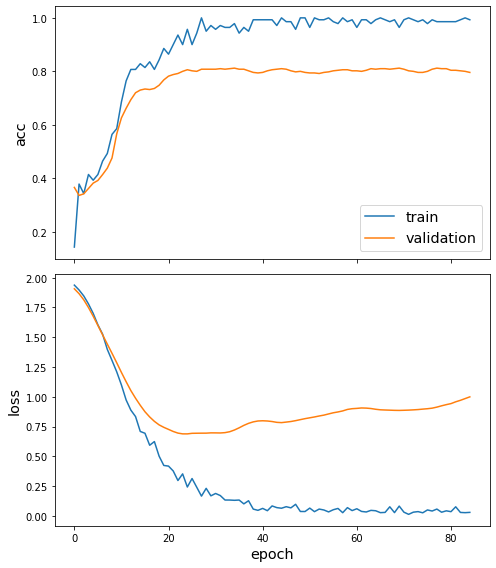

In [ ]:
sg.utils.plot_history(history)

As the final part of our evaluation, let's check the model against the test set. We again create the data required for this using the `flow` method on our `FullBatchNodeGenerator` from above, and can use the model's `evaluate` method to compute the metric values for the trained model.

As expected, the model performs similarly on the validation set during training and on the test set here.

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 62ms/step - loss: 0.7918 - acc: 0.8008

Test Set Metrics:
	loss: 0.7918
	acc: 0.8008


### Making predictions with the model

In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 129ms/step


These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specification to turn these values back to the original categories.

In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

Let's have a look at a few predictions after training the model:

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


## Conclusion

This notebook gave an example using the GCN algorithm to predict the class of nodes. Specifically, the subject of an academic paper in the Cora dataset. Our model used:

- the graph structure of the dataset, in the form of citation links between papers
- the 1433-dimensional feature vectors associated with each paper

This notebook ran through the following steps:

1. prepared the data using common data science libraries
2. built a TensorFlow Keras model and data generator with [the StellarGraph library](https://github.com/stellargraph/stellargraph) 
3. trained and evaluated it using TensorFlow and other libraries

#Node classification with Graph ATention Network (GAT)

Install NetworkX & stellar

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

## Importing Libraries

In [ ]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the CORA network

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [ ]:
set(node_subjects)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data


---
For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.


In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

Note using stratified sampling gives the following counts:

In [ ]:
from collections import Counter

Counter(train_subjects)

Counter({'Neural_Networks': 42,
         'Probabilistic_Methods': 22,
         'Reinforcement_Learning': 11,
         'Theory': 18,
         'Case_Based': 16,
         'Rule_Learning': 9,
         'Genetic_Algorithms': 22})

### Converting to numeric arrays


---

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

## Creating the GAT model in Keras

---


To feed data from the graph to the Keras model we need a generator. Since GAT is a full-batch model, we use the FullBatchNodeGenerator class to feed node features and graph adjacency matrix to the model.

In [ ]:
generator = FullBatchNodeGenerator(G, method="gat")

In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

Expose the input and output tensors of the GAT model for node prediction, via GAT.in_out_tensors() method:

In [ ]:
x_inp, predictions = gat.in_out_tensors()

### Training the model

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [ ]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 4s - loss: 2.0087 - acc: 0.2000 - val_loss: 1.8437 - val_acc: 0.3360 - 4s/epoch - 4s/step
Epoch 2/50
1/1 - 0s - loss: 1.8660 - acc: 0.3000 - val_loss: 1.7405 - val_acc: 0.4240 - 457ms/epoch - 457ms/step
Epoch 3/50
1/1 - 0s - loss: 1.7191 - acc: 0.3857 - val_loss: 1.6461 - val_acc: 0.4360 - 361ms/epoch - 361ms/step
Epoch 4/50
1/1 - 0s - loss: 1.6048 - acc: 0.5357 - val_loss: 1.5622 - val_acc: 0.4480 - 442ms/epoch - 442ms/step
Epoch 5/50
1/1 - 0s - loss: 1.5613 - acc: 0.4357 - val_loss: 1.4895 - val_acc: 0.4720 - 239ms/epoch - 239ms/step
Epoch 6/50
1/1 - 0s - loss: 1.4446 - acc: 0.5500 - val_loss: 1.4232 - val_acc: 0.5200 - 286ms/epoch - 286ms/step
Epoch 7/50
1/1 - 0s - loss: 1.4040 - acc: 0.5286 - val_loss: 1.3611 - val_acc: 0.5600 - 247ms/epoch - 247ms/step
Epoch 8/50
1/1 - 0s - loss: 1.3472 - acc: 0.5643 - val_loss: 1.3016 - val_acc: 0.6120 - 244ms/epoch - 244ms/step
Epoch 9/50
1/1 - 0s - loss: 1.2884 - acc: 0.6357 - val_loss: 1.2449 - val_acc: 0.6640 - 285ms/epoch - 

Plot the training history:

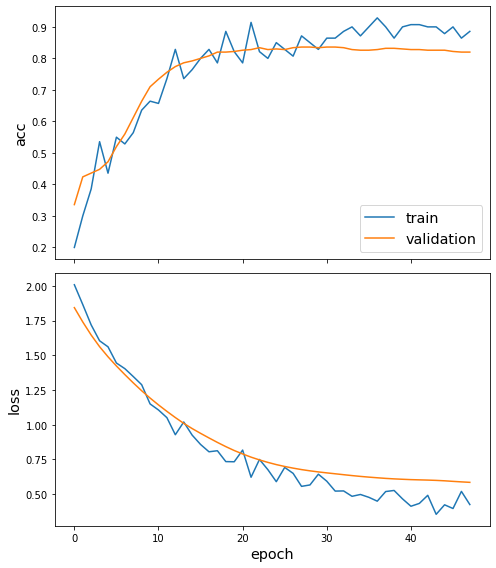

In [ ]:
sg.utils.plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [ ]:
model.load_weights("logs/best_model.h5")

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 187ms/step - loss: 0.6993 - acc: 0.8225

Test Set Metrics:
	loss: 0.6993
	acc: 0.8225


###Making predictions with the model

In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 1s 1s/step


In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Theory,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Theory,Neural_Networks
1106418,Theory,Theory


###Node Embeddings

In [ ]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
print(
    "Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape)
)

Embedding layer: graph_attention_sparse_2, output shape (1, 2708, 64)


In [ ]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)

The embeddings can now be calculated using the predict function. Note that the embeddings returned are 64 dimensional features (8 dimensions for each of the 8 attention heads) for all nodes.

In [ ]:
emb = embedding_model.predict(all_gen)
emb.shape

1/1 [==============================] - 1s 1s/step


(1, 2708, 64)

Projecting the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their true subject label

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [ ]:
X = emb.squeeze()
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [ ]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


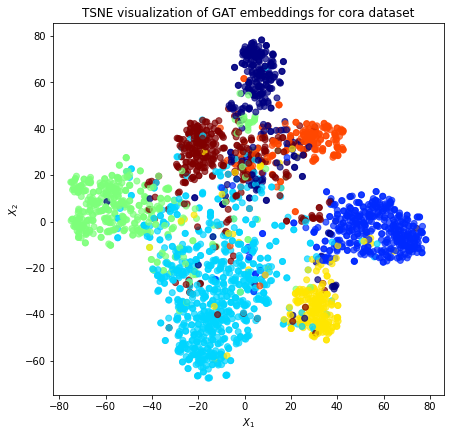

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GAT embeddings for cora dataset".format(transform.__name__)
)
plt.show()

#References:
#####https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html
#####https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html